# reading and viewing data

In [0]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

In [0]:
x, y = load_digits(n_class=10, return_X_y=True)

In [32]:
x.shape

(1797, 64)

0


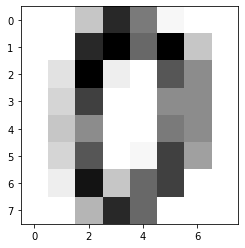

In [33]:
index = 0

print(y[index])
plt.imshow(x[index].reshape(8, 8), cmap="Greys")

In [34]:
x[index]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [35]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# preprocessing

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    shuffle=True, random_state=42)

In [38]:
x_train.shape

(1437, 64)

In [49]:
x_test.shape

(360, 64)

In [39]:
y_train.shape

(1437,)

In [40]:
scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# building a model

## pytorch CNN

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [0]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5, stride=1, padding=2)
    self.conv1_s = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=2, padding=2)
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
    self.conv2_s = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.conv3_s = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=2, padding=1)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(10, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv1_s(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv2_s(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv3_s(x))

    x = self.flatten(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x

In [0]:
batch_size = 64
learning_rate = 1e-3
epochs = 200

In [0]:
x_train_tensor = torch.tensor(x_train_scaled.reshape(-1, 1, 8, 8).astype(np.float32))
x_test_tensor = torch.tensor(x_test_scaled.reshape(-1, 1, 8, 8).astype(np.float32))

y_train_tensor = torch.tensor(y_train.astype(np.long))
y_test_tensor = torch.tensor(y_test.astype(np.long))

In [0]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [0]:
simple_cnn = SimpleCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(simple_cnn.parameters(), lr=learning_rate)

In [48]:
for epoch in range(epochs):
  simple_cnn.train()
  train_samples_count = 0
  true_train_samples_count = 0
  running_loss = 0

  for batch in train_loader:
    x_data = batch[0].cuda()
    y_data = batch[1].cuda()

    y_pred = simple_cnn(x_data)
    loss = criterion(y_pred, y_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    true_classified = (y_pred == y_data).sum().item()
    true_train_samples_count += true_classified
    train_samples_count += len(x_data)
  
  train_accuracy = true_train_samples_count / train_samples_count
  print(f"[{epoch}] train loss: {running_loss}, accuracy: {round(train_accuracy, 4)}")

  simple_cnn.eval()
  test_samples_count = 0
  true_test_samples_count = 0
  running_loss = 0

  for batch in test_loader:
    x_data = batch[0].cuda()
    y_data = batch[1].cuda()

    y_pred = simple_cnn(x_data)
    loss = criterion(y_pred, y_data)

    loss.backward()

    running_loss += loss.item()

    y_pred = y_pred.argmax(dim=1, keepdim=False)
    true_classified = (y_pred == y_data).sum().item()
    true_test_samples_count += true_classified
    test_samples_count += len(x_data)
  
  test_accuracy = true_test_samples_count / test_samples_count
  print(f"[{epoch}] test loss: {running_loss}, accuracy: {round(test_accuracy, 4)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0] train loss: 52.965962171554565, accuracy: 0.1016
[0] test loss: 13.812444686889648, accuracy: 0.0972
[1] train loss: 52.959094524383545, accuracy: 0.1016
[1] test loss: 13.810017824172974, accuracy: 0.0972
[2] train loss: 52.924052000045776, accuracy: 0.1065
[2] test loss: 13.791139125823975, accuracy: 0.1694
[3] train loss: 52.58355736732483, accuracy: 0.2317
[3] test loss: 13.570852279663086, accuracy: 0.1861
[4] train loss: 50.539629220962524, accuracy: 0.2276
[4] test loss: 12.984268188476562, accuracy: 0.325
[5] train loss: 48.47829580307007, accuracy: 0.373
[5] test loss: 12.617634296417236, accuracy: 0.3333
[6] train loss: 46.96195960044861, accuracy: 0.4154
[6] test loss: 12.29778242111206, accuracy: 0.4083
[7] train loss: 45.903536796569824, accuracy: 0.4711
[7] test loss: 12.03239119052887, accuracy: 0.4917
[8] train loss: 44.97504949569702, accuracy: 0.5268
[8] test loss: 11.841533660888672, accuracy: 0.5028
[9] train loss: 44.48520493507385, accuracy: 0.54
[9] test loss

## sklearn ensemble

In [0]:
import sklearn
from sklearn.ensemble import BaggingClassifier

In [0]:
class PytorchModel(sklearn.base.BaseEstimator):
  def __init__(self, net_type, net_params, optim_type, optim_params, loss_fn,
               input_shape, batch_size=32, accuracy_tol=0.02, tol_epochs=10,
               cuda=True):
    self.net_type = net_type
    self.net_params = net_params
    self.optim_type = optim_type
    self.optim_params = optim_params
    self.loss_fn = loss_fn

    self.input_shape = input_shape
    self.batch_size = batch_size
    self.accuracy_tol = accuracy_tol
    self.tol_epochs = tol_epochs
    self.cuda = cuda
  
  def fit(self, X, y):
    self.net = self.net_type(**self.net_params)
    if self.cuda:
      self.net = self.net.cuda()
    self.optim = self.optim_type(self.net.parameters(), **self.optim_params)

    uniq_classes = np.sort(np.unique(y))
    self.classes_ = uniq_classes

    X = X.reshape(-1, *self.input_shape)
    x_tensor = torch.tensor(X.astype(np.float32))
    y_tensor = torch.tensor(y.astype(np.long))
    train_dataset = TensorDataset(x_tensor, y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                              shuffle=True, drop_last=False)
    last_accuracies = []
    epoch = 0
    keep_training = True
    while keep_training:
      self.net.train()
      train_samples_count = 0
      true_train_samples_count = 0

      for batch in train_loader:
        x_data, y_data = batch[0], batch[1]
        if self.cuda:
          x_data = x_data.cuda()
          y_data = y_data.cuda()

        y_pred = self.net(x_data)
        loss = self.loss_fn(y_pred, y_data)

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        y_pred = y_pred.argmax(dim=1, keepdim=False)
        true_classified = (y_pred == y_data).sum().item()
        true_train_samples_count += true_classified
        train_samples_count += len(x_data)
      
      train_accuracy = true_train_samples_count / train_samples_count
      last_accuracies.append(train_accuracy)

      if len(last_accuracies) > self.tol_epochs:
        last_accuracies.pop(0)
      
      if len(last_accuracies) == self.tol_epochs:
        accuracy_difference = max(last_accuracies) - min(last_accuracies)
        if accuracy_difference <= self.accuracy_tol:
          keep_training = False

  def predict_proba(self, X, y=None):
    X = X.reshape(-1, *self.input_shape)
    x_tensor = torch.tensor(X.astype(np.float32))
    if y:
      y_tensor = torch.tensor(y.astype(np.long))
    else:
      y_tensor = torch.zeros(len(X), dtype=torch.long)
    test_dataset = TensorDataset(x_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                              shuffle=False, drop_last=False)

    self.net.eval()
    predictions = []
    for batch in test_loader:
      x_data, y_data = batch[0], batch[1]
      if self.cuda:
        x_data = x_data.cuda()
        y_data = y_data.cuda()

      y_pred = self.net(x_data)
      
      predictions.append(y_pred.detach().cpu().numpy())
    
    predictions = np.concatenate(predictions)
    return predictions
  
  def predict(self, X, y=None):
    predictions = self.predict_proba(X, y)
    predictions = predictions.argmax(axis=1)
    return predictions

In [0]:
base_model = PytorchModel(net_type=SimpleCNN, net_params=dict(), optim_type=Adam,
                          optim_params={"lr": 1e-3}, loss_fn=nn.CrossEntropyLoss(),
                          input_shape=(1, 8, 8), batch_size=32, accuracy_tol=0.02,
                          tol_epochs=10, cuda=True)

In [24]:
base_model.fit(x_train_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
preds = base_model.predict(x_test_scaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [26]:
true_classified = (preds == y_test).sum()
test_accuracy = true_classified / len(y_test)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.7361111111111112


In [0]:
meta_classifier = BaggingClassifier(base_estimator=base_model, n_estimators=10)

In [28]:
meta_classifier.fit(x_train_scaled.reshape(-1, 64), y_train)

BaggingClassifier(base_estimator=PytorchModel(accuracy_tol=0.02, batch_size=32,
                                              cuda=True, input_shape=(1, 8, 8),
                                              loss_fn=CrossEntropyLoss(),
                                              net_params={},
                                              net_type=<class '__main__.SimpleCNN'>,
                                              optim_params={'lr': 0.001},
                                              optim_type=<class 'torch.optim.adam.Adam'>,
                                              tol_epochs=10),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [29]:
meta_classifier.score(x_test_scaled.reshape(-1, 64), y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.95